# 0. 라이브러리 

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00


In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import joblib
import gc
import os

from tqdm import tqdm
import random
import logging
from IPython.display import display, HTML
import urllib.request

import seaborn as sns
import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

# import tensorflow_addons as tfa
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. data load

In [6]:
path = '/content/drive/MyDrive/Daegu_Complain_Classifficaion'

In [7]:
def csv_to_parquet(df, save_name):
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [8]:
name_list = ['BukGu', 'DalseongGun', 'DalsuGu', 'DongGu', 'JungGu', 'NamGu', 'SeoGu', 'Suseonggu']
complain_list = []

In [9]:
def load():
    for i, v in enumerate(name_list):
        complain_list.append(pd.read_csv(path + '/통합본/' + v + '.csv'))

In [10]:
def save():
    for i, v in enumerate(name_list):
        complain_list[i].to_csv(v + '.csv',index=False)

In [11]:
load()

In [12]:
for i, v in enumerate(complain_list):
    csv_to_parquet(v, name_list[i])
    complain_list[i] = pd.read_parquet(f'./{name_list[i]}.parquet')

BukGu Done.
DalseongGun Done.
DalsuGu Done.
DongGu Done.
JungGu Done.
NamGu Done.
SeoGu Done.
Suseonggu Done.


In [13]:
mode_df = pd.read_csv(path + '/통합본/mode_data.csv')

# 2. EDA

In [14]:
mode_df.head()

,BukGu_도시국_건설과,BukGu_도시국_도시행정과,BukGu_감사실,BukGu_도시국_건축주택과,BukGu_복지환경국_자원순환과,BukGu_복지환경국_환경관리과,BukGu_도시국_교통과,BukGu_문화녹지국_공원녹지과,BukGu_읍/면/동사무소,BukGu_도시국_도시관리과,...,Suseonggu_도시국_교통과,Suseonggu_도시국_건축과,Suseonggu_복지국_녹색환경과,Suseonggu_도시국_공원녹지과,Suseonggu_읍/면/동사무소,Suseonggu_도시국_도시디자인과,Suseonggu_보건소_보건행정과,Suseonggu_복지국_경제환경과,Suseonggu_교육문화국_문화체육과,Suseonggu_복지국_복지과
0,"('도로', 1197)","('불법', 108)","('불법', 6189)","('수', 1784)","('쓰레기', 817)","('소음', 478)","('주차', 3408)","('공원', 285)","('주민', 215)","('공원', 442)",...,"('주차', 3296)","('수', 3384)","('소음', 795)","('공원', 803)","('주민', 116)","('도로', 121)","('모기', 115)","('소음', 735)","('도서관', 343)","('수', 105)"
1,"('수', 1123)","('단속', 97)","('시장', 4369)","('시설', 1763)","('분리수거', 185)","('공사', 467)","('단속', 2172)","('나무', 131)","('일', 137)","('수', 275)",...,"('단속', 2138)","('수성', 3312)","('공사', 719)","('수성', 534)","('쓰레기', 74)","('주민', 109)","('보건소', 91)","('공사', 687)","('수', 326)","('어린이집', 96)"
2,"('건설', 966)","('민원', 97)","('건축', 4052)","('제조', 1753)","('행정', 182)","('쓰레기', 454)","('차량', 1774)","('수', 106)","('직원', 130)","('현수막', 224)",...,"('차량', 2034)","('아파트', 3251)","('수성', 370)","('수', 508)","('일', 70)","('수', 84)","('방역', 79)","('수', 466)","('수성', 213)","('아이', 88)"
3,"('민원', 875)","('물', 80)","('북', 3996)","('건축', 1738)","('수거', 172)","('수', 269)","('차', 1628)","('설치', 99)","('센터', 127)","('나무', 222)",...,"('차', 1645)","('분양', 2988)","('민원', 361)","('설치', 376)","('수', 64)","('불법', 84)","('수', 75)","('아파트', 297)","('사람', 206)","('장애', 84)"
4,"('분할', 800)","('광고', 72)","('행정', 3920)","('아파트', 1493)","('처리', 169)","('민원', 247)","('불법', 1253)","('북구', 94)","('사람', 125)","('주민', 212)",...,"('도로', 1497)","('공사', 2785)","('수', 332)","('주민', 336)","('가로등', 60)","('구청', 82)","('수성구', 57)","('민원', 273)","('테니스장', 206)","('등', 81)"


In [15]:
mode_df.shape

(10, 134)

In [ ]:
for i, v in enumerate(complain_list):
    print(name_list[i])
    print(complain_list[i].shape)

# 3. modeling

In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# from transformers import AutoModel, AutoTokenizer

# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

In [19]:
datasets = load_dataset("klue", 'ynat')

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/ynat/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
datasets["train"][0]

{'guid': 'ynat-v1_train_00000',
 'title': '유튜브 내달 2일까지 크리에이터 지원 공간 운영',
 'label': 3,
 'url': 'https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947',
 'date': '2016.06.30. 오전 10:36'}

In [21]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."

    picks = []
    
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)

        # 이미 등록된 예제가 뽑힌 경우, 다시 추출
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)

        picks.append(pick)

    # 임의로 추출된 인덱스들로 구성된 데이터 프레임 선언
    df = pd.DataFrame(dataset[picks])

    for column, typ in dataset.features.items():
        # 라벨 클래스를 스트링으로 변환
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])

    display(HTML(df.to_html()))

In [22]:
show_random_elements(datasets["train"])

,guid,title,label,url,date
0,ynat-v1_train_05342,또 불법보조금…갤럭시S9 일부 매장서 49만원,IT과학,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=731&oid=001&aid=0009948745,2018.03.11. 오전 9:24
1,ynat-v1_train_06824,삼성증권 일본 지진 국내 항공사에 부정적 영향,경제,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=258&oid=001&aid=0008342185,2016.04.19. 오전 8:31
2,ynat-v1_train_32658,中 크루즈 美의원 홍콩시위대 폭력 못봤다 발언에 발끈,세계,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=231&oid=001&aid=0011140691,2019.10.14. 오전 11:33
3,ynat-v1_train_10551,게시판 롯데카드 롯데리조트 기프티샷 출시…최대 45% 할인 이벤트,사회,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=259&oid=001&aid=0010569383,2019.01.09. 오전 9:36
4,ynat-v1_train_04349,EU 美의 징벌적 관세에 맞대응 예고…협상 기대감도 표시종합,세계,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=233&oid=001&aid=0011120631,2019.10.04. 오전 1:09
5,ynat-v1_train_06814,주목받는 충청모임…충청대망론 불지피나,정치,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=100&sid2=265&oid=001&aid=0008408409,2016.05.17. 오후 6:33
6,ynat-v1_train_21849,제주소식 TBN 제주 개국 2주년 14시간 특별생방송,생활문화,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=102&sid2=254&oid=001&aid=0010269336,2018.08.14. 오후 2:23
7,ynat-v1_train_38983,SKT CMMI 인증으로 사물인터넷 사업역량 인정,IT과학,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008718964,2016.09.30. 오전 10:32
8,ynat-v1_train_05520,평화 워크숍서 당 진로 두고 난상토론…통합 논의 화두로,정치,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=100&sid2=269&oid=001&aid=0010652723,2019.02.22. 오후 9:48
9,ynat-v1_train_38162,北 南 해외 일꾼에 이메일 살포해 탈북선동 주장,정치,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=100&sid2=268&oid=001&aid=0008908136,2016.12.22. 오후 12:03


## 1) target labelencoding

In [23]:
np.unique(complain_list[0]['dept'])

array(['감사실', '도시국 건설과', '도시국 건축주택과', '도시국 교통과', '도시국 도시관리과', '도시국 도시행정과',
       '도시국 재난안전과', '문화녹지국 공원녹지과', '복지환경국 자원순환과', '복지환경국 환경관리과',
       '읍/면/동사무소', '주민생활지원국 환경관리과'], dtype=object)

In [24]:
complain_list[0]

,content,dept
0,매천동 청구 장미아파트 삼우 그린 입구 불합리 위치 매천동 청구 장미아파트 삼우 그...,도시국 건설과
1,처리 중 언제까지 어린이보호구역 불법주차 불법적 재 신고한 지가 언제인데 아직 처리...,도시국 도시행정과
2,도로 개설 본인은 대구시 북구 태전동 번지 토지 소유자입니다 현재 상기 토지에서 농...,도시국 건설과
3,북구청장 감사실은 뭐 하는 곳입니까 묻습니다 불법에 대한 최고의 북구 전문가 북구청...,감사실
4,대구시장 북구청장 감사실은 뭐 하는 부서입니까 감사실 폐쇄하셔요 미관지구 대구시장 ...,감사실
...,...,...
6831,같은 건물 같은 층에 있는 헬스클럽 소음 규제 방법은요 산격동 번지 층입니다 대현 ...,주민생활지원국 환경관리과
6832,가로등 수리 검단동 가로등 수리 좀 해 주세요 곰 레미콘에서 민들레 아파트까지 수고하세요,도시국 건설과
6833,견인하는 곳에서는 카드 결제가 안 되나요 안녕하세요 우선 견인된 장소에서 차를 찾으...,도시국 교통과
6834,재건축 시행사의 불법 복현주공 단지 아파트에 살고 있는 주민입니다 재건축을 한다고 ...,도시국 건축주택과


In [25]:
from sklearn.preprocessing import LabelEncoder
le_list = [LabelEncoder() for _ in range(len(complain_list))]

In [26]:
for i, v in enumerate(complain_list):
    v['dept'] = le_list[i].fit_transform(v['dept'])

In [27]:
complain_list[0], le_list[0].classes_, len(le_list[0].classes_)

(                                                content  dept
 0     매천동 청구 장미아파트 삼우 그린 입구 불합리 위치 매천동 청구 장미아파트 삼우 그...     1
 1     처리 중 언제까지 어린이보호구역 불법주차 불법적 재 신고한 지가 언제인데 아직 처리...     5
 2     도로 개설 본인은 대구시 북구 태전동 번지 토지 소유자입니다 현재 상기 토지에서 농...     1
 3     북구청장 감사실은 뭐 하는 곳입니까 묻습니다 불법에 대한 최고의 북구 전문가 북구청...     0
 4     대구시장 북구청장 감사실은 뭐 하는 부서입니까 감사실 폐쇄하셔요 미관지구 대구시장 ...     0
 ...                                                 ...   ...
 6831  같은 건물 같은 층에 있는 헬스클럽 소음 규제 방법은요 산격동 번지 층입니다 대현 ...    11
 6832  가로등 수리 검단동 가로등 수리 좀 해 주세요 곰 레미콘에서 민들레 아파트까지 수고하세요     1
 6833  견인하는 곳에서는 카드 결제가 안 되나요 안녕하세요 우선 견인된 장소에서 차를 찾으...     3
 6834  재건축 시행사의 불법 복현주공 단지 아파트에 살고 있는 주민입니다 재건축을 한다고 ...     2
 6835  분양승인 후 청약접수 일정 연기에 관한 문의 기존 주택법상 공동주택의 경우 모집공고...     2
 
 [6836 rows x 2 columns],
 array(['감사실', '도시국 건설과', '도시국 건축주택과', '도시국 교통과', '도시국 도시관리과', '도시국 도시행정과',
        '도시국 재난안전과', '문화녹지국 공원녹지과', '복지환경국 자원순환과', '복지환경국 환경관리과',
        '읍/면/동사무소', '주민생활지원국 환경관리과'], dtype=object),
 12)

In [28]:
for i, v in enumerate(complain_list):
    print(name_list[i])
    print(v['dept'].value_counts())

BukGu
0     1425
2     1153
3     1118
1     1029
11     437
4      391
6      364
9      324
7      223
8      183
10      98
5       91
Name: dept, dtype: int64
DalseongGun
1     524
6     449
0     398
9     212
11    189
14    163
5     113
2      99
4      88
3      70
8      64
12     59
10     36
7      34
15     31
13     29
Name: dept, dtype: int64
DalsuGu
4     1202
9      584
8      552
7      506
5      435
10     410
6      260
2      229
12     216
15     192
11     139
0      125
14     113
3       90
13      77
16      66
1       60
Name: dept, dtype: int64
DongGu
4     554
2     553
3     498
11    386
9     384
1     274
18    263
8     235
5     147
10    144
15    133
7     126
13    100
14     86
12     83
19     81
17     80
6      67
0      65
16     60
Name: dept, dtype: int64
JungGu
4     628
20    404
7     391
3     134
12    115
21    102
8      92
15     77
5      72
10     71
11     61
17     56
0      56
16     52
19     50
9      47
18     47
6      42
1

## 2) text_len 확인

In [29]:
for i, v in enumerate(complain_list):
    v['content_len'] = v['content'].str.len()

In [30]:
for i, v in enumerate(complain_list):
    v['content_len'] = v['content'].str.len()

BukGu


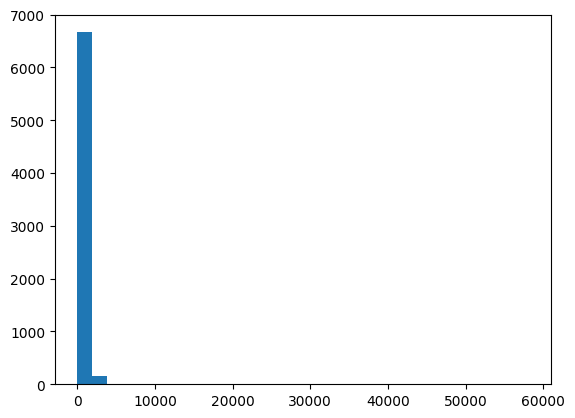

DalseongGun


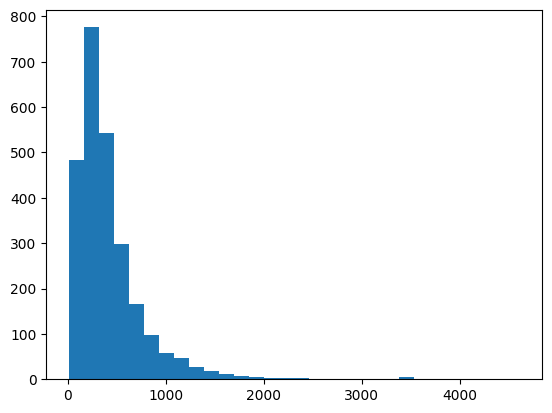

DalsuGu


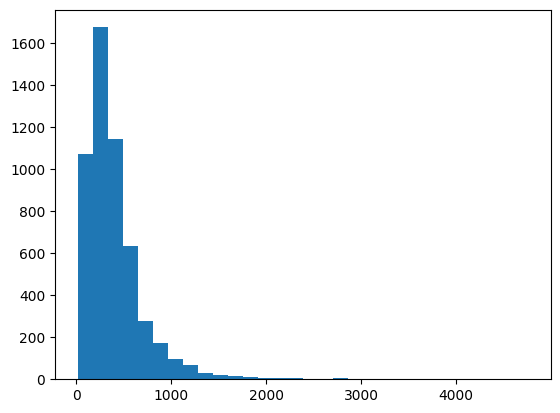

DongGu


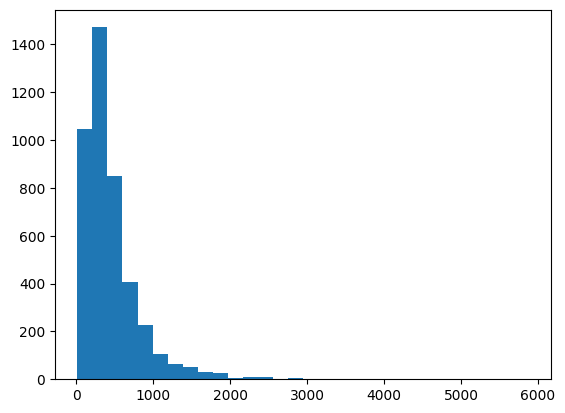

JungGu


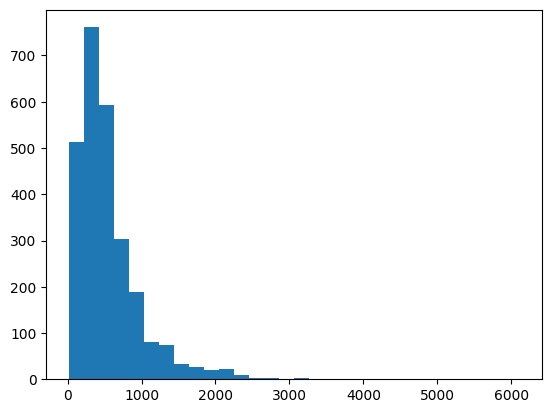

NamGu


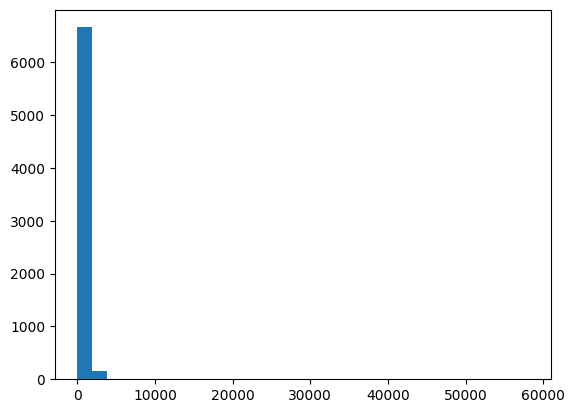

SeoGu


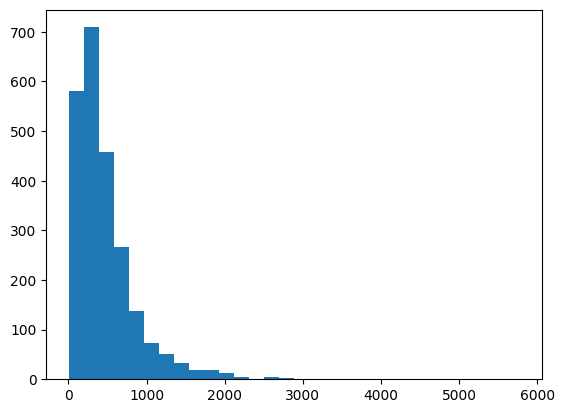

Suseonggu


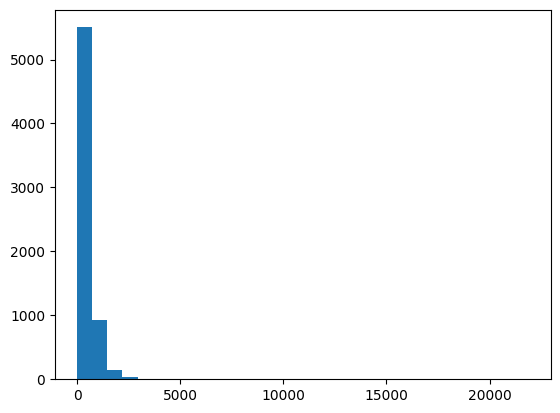

In [31]:
for i, v in enumerate(complain_list):
    print(name_list[i])
    plt.hist(v['content_len'], bins=30)
    plt.show()

In [32]:
for i, v in enumerate(complain_list):
    print(name_list[i])
    print(v['content_len'].describe())

BukGu
count     6836.000000
mean       570.787156
std        875.148169
min          9.000000
25%        244.000000
50%        404.000000
75%        676.000000
max      58077.000000
Name: content_len, dtype: float64
DalseongGun
count    2558.000000
mean      415.605942
std       364.681220
min         9.000000
25%       191.250000
50%       319.000000
75%       518.500000
max      4609.000000
Name: content_len, dtype: float64
DalsuGu
count    5256.000000
mean      398.219939
std       341.413070
min        12.000000
25%       193.000000
50%       317.000000
75%       495.000000
max      4762.000000
Name: content_len, dtype: float64
DongGu
count    4319.000000
mean      454.691364
std       402.693476
min        12.000000
25%       213.000000
50%       349.000000
75%       557.000000
max      5876.000000
Name: content_len, dtype: float64
JungGu
count    2632.000000
mean      542.134498
std       439.267472
min        15.000000
25%       251.000000
50%       436.000000
75%       676.2500

# 5. train test split

In [ ]:
i = 0

In [33]:
# 입출력 데이터 분리
X_data = complain_list[i]['content']
y_data = complain_list[i]['dept']

In [34]:
X_data.shape, y_data.shape

((6836,), (6836,))

In [35]:
np.unique(y_data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [36]:
y_data.value_counts()

0     1425
2     1153
3     1118
1     1029
11     437
4      391
6      364
9      324
7      223
8      183
10      98
5       91
Name: dept, dtype: int64

In [100]:
TEST_SIZE = 0.15 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
# strtify = True 일 경우, 데이터 분리 이전의 라벨별 분포 고려
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_train)

In [101]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"검증 입력 데이터 개수: {len(X_val)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 4938
검증 입력 데이터 개수: 872
테스트 입력 데이터 개수: 1026


In [102]:
y_test.value_counts()

0     214
2     173
3     168
1     154
11     65
4      59
6      55
9      49
7      33
8      27
10     15
5      14
Name: dept, dtype: int64

# BERT 입력용 데이터 포맷으로 변경

In [40]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 1000

In [41]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [103]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

4938it [00:03, 1267.74it/s]


In [104]:
# val 데이터를 Bert의 Input 타입에 맞게 변환
val_x, val_y = convert_data(X_val, y_val)

872it [00:00, 1268.05it/s]


In [105]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

1026it [00:00, 1301.43it/s]


In [45]:
NUM_CLASS = len(np.unique(y_train))
NUM_CLASS

12

In [46]:
from transformers import TFBertForSequenceClassification, AutoTokenizer

model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=NUM_CLASS, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
complain_list[0].iloc[0]['content']

'매천동 청구 장미아파트 삼우 그린 입구 불합리 위치 매천동 청구 장미아파트 삼우 그린아파트 들어가는 입구 매천 생활용품 바로 옆 진입로 내용 사람들이 자주 이용하는 횡단보도가 있고 아파트로 들어가는 차량들이 많이 다님에도 불구하고 새벽에 매천 생활용품점과 자동차 수리점이 문을 닫는 시간이 되면 거리가 너무 어두컴컴해서 보행자를 칠 우려가 있음 자동차 우측 사각지대 늦은 밤 어두컴컴한 거리 꼭 매천 생활용품점과 자동차 수리점이 문을 닫는 시간대 거리에 조명시설 확인 후 조치해야 할 것입니다 사진도 첨부합니다'

In [48]:
tokenizer(complain_list[0].iloc[0]['content'], max_length=10, truncation=True)

{'input_ids': [2, 1050, 16183, 5300, 9123, 2227, 2160, 2265, 1238, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [49]:
ids_1 = tokenizer(complain_list[0].iloc[0]['content'], max_length=10, truncation=True)['input_ids']

In [50]:
tokenizer.convert_ids_to_tokens(ids_1)

['[CLS]', '매', '##천동', '청구', '장미', '##아', '##파', '##트', '삼', '[SEP]']

In [51]:
temp = tokenizer.tokenize(complain_list[0].iloc[0]['content'], max_length=10, truncation=True)

In [52]:
ids = tokenizer.convert_tokens_to_ids(temp)

In [53]:
ids

[1050, 16183, 5300, 9123, 2227, 2160, 2265, 1238, 2137, 5207]

In [54]:
tokenizer.convert_ids_to_tokens(ids)

['매', '##천동', '청구', '장미', '##아', '##파', '##트', '삼', '##우', '그린']

In [57]:
tokenizer(complain_list[0].iloc[0]['content'], max_length=10, truncation=True)

{'input_ids': [2, 1050, 16183, 5300, 9123, 2227, 2160, 2265, 1238, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [58]:
import tensorflow as tf

token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')

bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [59]:
bert_outputs

TFSequenceClassifierOutput(loss=None, logits=<KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'tf_bert_for_sequence_classification')>, hidden_states=None, attentions=None)

In [60]:
bert_output = bert_outputs[0]

In [61]:
len(train_x[0][0]), MAX_SEQ_LEN

(1000, 1000)

## 모델 컴파일

In [62]:
len(np.unique(y_train))

12

In [63]:
keras.backend.clear_session()

In [64]:
DROPOUT_RATE = 0.5
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [65]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS, 
                                          warmup_proportion = WARMUP_PROPORTION, 
                                          min_lr = MIN_LR, 
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [66]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [67]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 1000)]       0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 1000)]       0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 1000)]       0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  110626572  ['input_word_ids[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_masks[0][0]',        

## 조기종료 조건

In [ ]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = MIN_DELTA,
    patience = PATIENCE,
    restore_best_weight = True)

## 최고 성능 모델 저장

In [80]:
version = '기본'
path_result = '/content/drive/MyDrive/Daegu_Complain_Classifficaion/모델링/pretrained_model/' + version + '/' + name_list[i]

In [91]:
os.mkdir(path_result + '/model')
os.mkdir(path_result + '/metric')
os.mkdir(path_result + '/figure')

In [ ]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = path_result + '/model/best_model.h5'

In [110]:
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_accuracy",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [83]:
callbacks = [early_stopping, model_checkpoint]

## 감정 분류 모델 학습

In [84]:
len(np.unique(y_train)), len(np.unique(y_val)), len(np.unique(y_val))

(12, 12, 12)

In [85]:
EPOCHS = 100
BATCH_SZIE = 8

In [86]:
sentiment_model.fit(train_x, train_y, 
                    epochs = EPOCHS, 
                    shuffle = True, 
                    batch_size = BATCH_SZIE, 
                    validation_data = (val_x, val_y),
                    callbacks = callbacks
                    )

Epoch 1/100
618/618 [==============================] - ETA: 0s - loss: 2.1483 - accuracy: 0.4123
Epoch 1: val_loss improved from inf to 1.82866, saving model to /content/drive/MyDrive/Daegu_Complain_Classifficaion/모델링/pretrained_model/기본/Suseonggu/model/best_model.h5
618/618 [==============================] - 205s 331ms/step - loss: 2.1483 - accuracy: 0.4123 - val_loss: 1.8287 - val_accuracy: 0.5115
Epoch 2/100
618/618 [==============================] - ETA: 0s - loss: 1.6174 - accuracy: 0.5658
Epoch 2: val_loss improved from 1.82866 to 1.30092, saving model to /content/drive/MyDrive/Daegu_Complain_Classifficaion/모델링/pretrained_model/기본/Suseonggu/model/best_model.h5
618/618 [==============================] - 227s 367ms/step - loss: 1.6174 - accuracy: 0.5658 - val_loss: 1.3009 - val_accuracy: 0.6972
Epoch 3/100
618/618 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.6691
Epoch 3: val_loss improved from 1.30092 to 1.11683, saving model to /content/drive/

# 감정 분류의 예측값 계산

In [87]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [107]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

33/33 [==============================] - 11s 339ms/step


In [99]:
np.array(test_x).shape

(3, 6836, 1000)

# 감정 분류 모델의 성능 평가

## Classification Report

In [115]:
pd.Series(train_y).value_counts()

0     1029
2      833
3      807
1      744
11     316
4      282
6      263
9      234
7      161
8      133
10      71
5       65
dtype: int64

In [116]:
pd.Series(val_y).value_counts()

0     182
2     147
3     143
1     131
11     56
4      50
6      46
9      41
7      29
8      23
10     12
5      12
dtype: int64

In [114]:
pd.Series(test_y).value_counts()

0     214
2     173
3     168
1     154
11     65
4      59
6      55
9      49
7      33
8      27
10     15
5      14
dtype: int64

In [108]:
# Classification Report 저장
CL_REPORT_FILE = path_result + "/metric/cl_report.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True, zero_division=0)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score   support
0                 0.954   0.972     0.963   214.000
1                 0.889   0.727     0.800   154.000
2                 0.940   0.815     0.873   173.000
3                 0.840   0.940     0.888   168.000
4                 0.534   0.932     0.679    59.000
5                 0.000   0.000     0.000    14.000
6                 0.800   0.873     0.835    55.000
7                 0.000   0.000     0.000    33.000
8                 0.000   0.000     0.000    27.000
9                 0.571   0.163     0.254    49.000
10                0.786   0.733     0.759    15.000
11                0.373   0.877     0.523    65.000
accuracy          0.778   0.778     0.778     0.778
macro avg         0.557   0.586     0.548  1026.000
weighted avg      0.765   0.778     0.754  1026.000


In [109]:
le_list[0].classes_

array(['감사실', '도시국 건설과', '도시국 건축주택과', '도시국 교통과', '도시국 도시관리과', '도시국 도시행정과',
       '도시국 재난안전과', '문화녹지국 공원녹지과', '복지환경국 자원순환과', '복지환경국 환경관리과',
       '읍/면/동사무소', '주민생활지원국 환경관리과'], dtype=object)

In [112]:
# 점수가 0이거나 낮은 class
le_list[0].inverse_transform([4, 5, 7, 8, 9, 11])

array(['도시국 도시관리과', '도시국 도시행정과', '문화녹지국 공원녹지과', '복지환경국 자원순환과',
       '복지환경국 환경관리과', '주민생활지원국 환경관리과'], dtype=object)

## Confusion Matrix

In [ ]:
# 이미지 파일 저장정보
FIGURE_FILE = path_result + "/figure/cf_matrix.png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(FIGURE_FILE)
plt.show()

## 전체 평가지표

In [ ]:
# Multi-class Classification의 대중적인 평가 지표 모두 확인
accuracy_score_v = round(accuracy_score(y_test, predicted_label), 3) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 3) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 3) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 3) # F1 Score
roc_auc_score_v = round(roc_auc_score(y_test, predicted_value, average="weighted", multi_class="ovr"), 3) # ROC AUC Score
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 3) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 3) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(y_test, predicted_value), 3) # Log Loss

In [ ]:
METRIC_FILE = path_result + '/metric/metric.csv'

In [ ]:
# 평가지표 결과 저장
metric_total = pd.DataFrame({
    'PLM': MODEL_NAME,
    'Optimizer': OPTIMIZER_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'ROC_AUC_score': roc_auc_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['-']
    )

In [ ]:
metric_total.to_csv(METRIC_FILE)

In [ ]:
print(metric_total)